# 目的
- 重量分布を可視化する


In [1]:
import sys, os
import sqlite3
import numpy as np
import pandas as pd
import scipy.stats as stats

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns, numpy as np

import ChocoUtils as cu

In [2]:
sns.set()

# load data

In [3]:
data = cu.get_data(db_file='../..//data/choco-ball.db', filter_str="taste is not 10")
data = data.drop(columns=['factory'])
#data.head()

SELECT measure_date, best_before, prd_number, weight, box_weight, ball_number, factory, shop, angel, campaign, taste, buyer, (weight - box_weight), (weight - box_weight)/ball_number FROM measurement WHERE taste is not 10;
Shape of MeasurementData(record_num, n_columns) : (636, 14)


In [4]:
tastes = pd.read_csv('../../data/choco_tastes.csv')
#tastes.head()

In [5]:
data = pd.merge(data, tastes, left_on='taste', right_on='id')

In [6]:
data.groupby(['taste', 'name_en']).count()[['weight']].sort_values(by='weight', ascending=False)

,,weight
taste,name_en,
0,peanut,454
1,strawberry,57
12,banana,43
11,m-catamel,16
13,peanut-white,14
4,amazake,10
7,pachipachi,10
15,hichew-grape,6
2,kinako,5


# 単純なplot

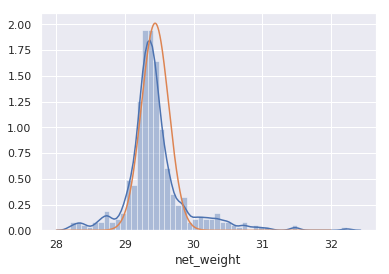

In [12]:
data_peanut = data[data.name_en == 'peanut']

sns.distplot(data_peanut.net_weight)

var_ml = np.var(data_peanut.net_weight)
mu_ml = np.mean(data_peanut.net_weight)
xs = np.linspace(28, 32, 1000)
p = list(map(lambda x:stats.norm.pdf(x, loc=mu_ml, scale=var_ml), xs))
plt.plot(xs, p)

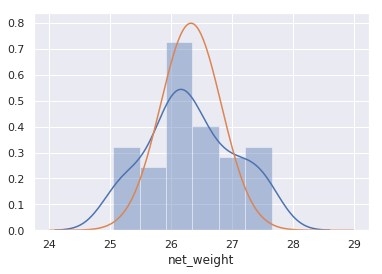

In [14]:
data_strawberry = data[data.name_en == 'strawberry']

sns.distplot(data_strawberry.net_weight)

var_ml = np.var(data_strawberry.net_weight)
mu_ml = np.mean(data_strawberry.net_weight)
xs = np.linspace(24, 29, 1000)
p = list(map(lambda x:stats.norm.pdf(x, loc=mu_ml, scale=var_ml), xs))
plt.plot(xs, p)

In [ ]:
# 仕様の重量
spec = {0:28.0, 1:25.0, 4:22.0, 7:26.0, 10:22.0}
taste_name = {0:"peanut", 1:"strawberry", 4:"ama-zake", 7:"pachi-pachi", 10:"pineapple"}

In [ ]:
fig = plt.figure(figsize=(6, 4))
ax = fig.subplots(1, 1)

bins = np.linspace(27., 35., 100)
ret = ax.hist(data['net_weight'], 
               bins=bins, color="#0000FF", alpha=0.5, edgecolor="#0000FF", 
               label='measure')
ax.set_xlabel("NetWeight [g]")
ax.legend()


該当の日付のみ色分けしてplot

In [ ]:
#data['measure_date_t'] = pd.to_datetime(data['measure_date'], format='%Y-%m-%d')
data['measure_date_t'] = pd.to_datetime(data['best_before'], format='%Y-%m-%d')

In [ ]:
#timeThresh = '2018-11-07'
timeThresh = '2019-06-01'
w_list = [data.loc[data['measure_date_t']<pd.to_datetime(timeThresh)]['net_weight'], 
          data.loc[data['measure_date_t']>=pd.to_datetime(timeThresh)]['net_weight']]

In [ ]:
fig = plt.figure(figsize=(10,4))
ax = fig.subplots(1, 1)

ax.hist(w_list, bins=bins, color=['#0000FF', '#FF0000'], alpha=0.5, 
        label=['{}<'.format(timeThresh), '>={}'.format(timeThresh)], 
        histtype='bar', stacked=True)
ax.set_xlabel('NetWeight [g]')
ax.set_ylabel('freq')
ax.legend()
fig.savefig("weight_dist_peanuts.png")

In [ ]:
import pymc as pm

In [ ]:
def getEstimatedWeightDist(values, spec, n_sample=15000, n_burn=5000):
    # 精度$\tau$(分散の逆数)
    tau = 1.0 / pm.Uniform("std", 0, 100)**2
    # 分布の中心
    ## 事前分布の中心として製品仕様を、tauを0.01(分散=100)
    center = pm.Normal("center", spec, 0.01)
    # 観測とモデルを結びつける
    observations = pm.Normal("obs", center, tau, value=values, observed=True)
    # Modelオブジェクト生成
    model = pm.Model([tau, center])
    
    # MCMC
    mcmc = pm.MCMC(model)
    mcmc.sample(n_sample, n_burn)
    
    return mcmc.trace("center")[:], mcmc.trace("std")[:]

In [ ]:
fig = plt.figure(figsize=(10, 4))
ax = fig.subplots(1, 1)

bins = np.linspace(0, 3.0, 100)
labs = ['{}<'.format(timeThresh), '>={}'.format(timeThresh)]
for i, value in enumerate(w_list):
    e_center, e_std = getEstimatedWeightDist(values=value, spec=28)
    sns.distplot((e_center-28), bins=bins, label=labs[i], ax=ax)
ax.set_title('estimated weight dist. (spec=0)')
ax.set_xlabel("(NetWeight - Spec) [g]")
ax.legend()
fig.savefig("weight_estimate_bayes_peanuts.png")